# Evaluation for the models

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import random
import os

In [ ]:
# When we were using google colab

# from google.colab import drive
# drive.mount('/content/drive')

## Function definitions

In [3]:
path='C:\Adrian\Egyetem-Msc\Deep Learning Python es LUA alapon\Project\landmark-recognition-2021'

# When using Google Colab: # "/content/drive/MyDrive/MSc/1. félév/Deep Learning/Nagyházi"

In [4]:
def top_p_percent_acc(data, p):
    cat_num=len(list(data.columns))-2  #number of categories = number of columns - 2 (number of picture, true_label)
    val_size=len(list(data.index)) #number of validation data points
    p_percent=int(p/100*cat_num) #p percent of the validation size
    acc=0
    for row,i in data.iterrows():
        best_p_indices=np.array(i[:len(i)-2]).argsort()[-p_percent:][::-1]  #the p% largest probabilities
        best_p_columns=[data.columns[j] for j in best_p_indices]  #the corresponding classes
        true_label=str(int(i["original_class"])) #str(train.loc[i["picture"],"landmark_id"])  #the true class of the data point
        if true_label in best_p_columns:
            acc+=1
    acc=acc/val_size
    return acc

In [5]:
def top_p_percent_plot(data, P_list, title, color):
    cat_num=len(list(data.columns))-2  #number of categories = number of columns - 2 (number of picture, true_label)
    val_size=len(list(data.index)) #number of validation data points

    #values=[]
    #for p in P_list:
        #acc=top_p_percent_acc(data, p)
        #values.append(acc)

    values=[top_p_percent_acc(data, p) for p in P_list]

    plt.plot(P_list, values, color=color)
    plt.plot(P_list, [1 for i in range(len(P_list))], color="black", alpha=0.5)
    plt.title('P-percent accuracies for'+title)
    plt.xlabel('P values')
    plt.ylabel('P-accuracy')
    plt.ylim([0, 1.05])
    plt.show()

In [17]:
def plot_example(class_name):
  #from the train csv file we are searching for those image ids that have the class_name as landmark_id and add them to a list
  image_ids = train[train['landmark_id'] == int(class_name)]['id'].values

  mainpath = 'C:\Adrian\Egyetem-Msc\Deep Learning Python es LUA alapon\Project\landmark-recognition-2021\\train'
  image_path = []

  # We have to create the directories for the pictures, we could also use os.listdir, but this was less complicated
  for i in range(0,len(image_ids)):
      first_dir = os.path.join(mainpath,image_ids[i][0])
      second_dir = os.path.join(first_dir,image_ids[i][1])
      third_dir = os.path.join(second_dir,image_ids[i][2])
      finalpath = os.path.join(third_dir,image_ids[i]+'.jpg')

      image_path.append(finalpath)

  #plotting 5 images from our class
  fig = plt.gcf()
  fig.set_size_inches(16, 16)
  next_pix = image_path
  random.shuffle(next_pix)
  for i, img_path in enumerate(next_pix[0:5]):
      sp = plt.subplot(1, 5, i + 1)
      sp.axis('Off')
      img = mpimg.imread(img_path)
      plt.imshow(img)
  plt.show()

In [7]:
def best_worst_class(data, n, p):
    accuracies=[] #this list will contain the accuracies of the classes
    for class_num in data.columns[:len(data.columns)-2]:
        class_data=data[data["original_class"]==float(class_num)]  #validation data points from this class
        acc=top_p_percent_acc(class_data, p)    #accuracy of the validation data from this class
        accuracies.append(acc)
    best_n_index=np.array(accuracies).argsort()[-n:][::-1]  #the indices of the n highest accuracy
    best_n_class=[class_data.columns[j] for j in best_n_index] #the n corresponding classes
    best_n_accuracy=[accuracies[j] for j in best_n_index]  #the n highest accuracy
    worst_n_index=np.array(accuracies).argsort()[:n]  #the indices of the n lowest accuracy
    worst_n_class=[class_data.columns[j] for j in worst_n_index] #the n corresponding classes
    worst_n_accuracy=[accuracies[j] for j in worst_n_index] #the n lowest accuracy

    print(f"The {n} highest {p}-percent accuracy: {best_n_accuracy}")
    #print(f"The best {n} classes: {best_n_class}")
    print(f"Some examples from these {n} classes:")
    for i in best_n_class:
        plot_example(i)  #plot some picture from these classes -> it can be seen why it was so easy/difficult to classify these pictures
    print(f"The {n} lowest {p}-percent accuracy: {worst_n_accuracy}")
    #print(f"The worst {n} classes: {worst_n_class}")
    print(f"Some examples from these {n} classes:")
    for i in worst_n_class:
        plot_example(i)


In [8]:
def acc_class_size(data):  #we would like to investigate if the the accuracy and the size of the class are correlated
    accuracies=[] #this list will contain the accuracies of the classes
    sizes=[]
    for class_num in data.columns[:len(data.columns)-2]:
        class_data=data[data["original_class"]==float(class_num)]  #validation data points from this class
        acc=top_p_percent_acc(class_data, 2)    #accuracy of the validation data from this class
        accuracies.append(acc)
        class_size=train[train["landmark_id"]==float(class_num)]["label_count"].values[0] #size of the class
        sizes.append(class_size)
    order=np.array(accuracies).argsort() #order the two list according to the accuracies
    accuracies=[accuracies[i] for i in order]
    sizes=[sizes[i] for i in order]
    sizes=[(sizes[i]-min(sizes))/(max(sizes)-min(sizes)) for i in range(len(sizes))] #normalize the sizes into [0, 1]
    corr=round(np.corrcoef(accuracies, sizes)[0, 1],4)
    label="corr="+str(corr)
    plt.scatter(accuracies, sizes, label=label)
    plt.ylabel("Size of the class")
    plt.xlabel("Accuracy of the class")
    plt.legend()
    plt.show()


In [9]:
train=pd.read_csv(f"{path}/train_corrected.csv")
train.head()

Unnamed: 0                id  landmark_id  label_count  encoded_landmark_id
0     1081003  9a126324e671e76c       138982         6272                    0
1     1077888  1a4519d92d84b71f       138982         6272                    0
2     1077866  1939983af1b00f72       138982         6272                    0
3     1077867  1941e9371698fc3a       138982         6272                    0
4     1077868  195159c30049fa4e       138982         6272                    0

## with 50 classes:
We made a model, which predictied only for the largest 50 classes of the data. This was the most succesful model, because it had the best accuracy.

In [10]:
resnet50_pred_50classes=pd.read_csv(f'{path}/Resnet50_encdingFixed_50classes_val_pred.csv')
resnet50_pred_50classes.head(5)

138982        126637         20409         83144        113209  \
0  4.427890e-10  9.606546e-01  2.905655e-02  4.474935e-06  1.118125e-13   
1  6.066378e-09  1.750459e-05  2.104381e-05  3.801146e-06  8.331301e-07   
2  5.348528e-05  5.571348e-01  7.272437e-05  8.142236e-03  6.678970e-03   
3  1.000000e+00  1.676887e-19  4.837625e-22  1.825649e-24  2.618566e-31   
4  1.281453e-08  1.129041e-03  3.131919e-06  3.848836e-03  9.028728e-06   

         177870        194914        149980        139894          1924  ...  \
0  2.182501e-04  1.370927e-03  1.143879e-06  1.062236e-08  3.299355e-08  ...   
1  1.758678e-05  8.140135e-08  4.793713e-05  2.906235e-06  2.167012e-04  ...   
2  3.176649e-02  2.801980e-04  7.061722e-03  4.661689e-05  2.725603e-02  ...   
3  3.642939e-20  1.680591e-31  9.635039e-25  4.243743e-23  2.768296e-27  ...   
4  4.808039e-04  9.046505e-01  1.254946e-04  2.192562e-06  1.808405e-04  ...   

          64792         80177         27190        152708        143710  \
0  3.411397e-06  3.324194e-07  1.754975e-10  7.054383e-08  4.615209e-05   
1  3.978935e-06  1.890422e-08  5.582183e-06  1.507034e-05  1.230194e-04   
2  3.673971e-03  8.448251e-05  3.273473e-04  4.836184e-03  3.042392e-03   
3  1.351033e-21  1.409202e-25  4.050126e-27  1.702273e-20  9.185264e-25   
4  3.329237e-04  3.983239e-11  3.163037e-08  2.975929e-05  4.084452e-05   

          31531            27        113838  picture  original_class  
0  4.310033e-10  2.222277e-07  1.371590e-05   982852          126637  
1  8.064603e-06  6.552651e-06  1.087854e-07  1484860          190822  
2  5.539741e-04  5.347290e-03  7.275189e-04  1285446          165596  
3  2.462957e-24  5.256739e-24  3.604986e-23  1077338          138982  
4  1.142680e-04  5.990778e-05  4.509418e-04  1518286          194914  

[5 rows x 52 columns]

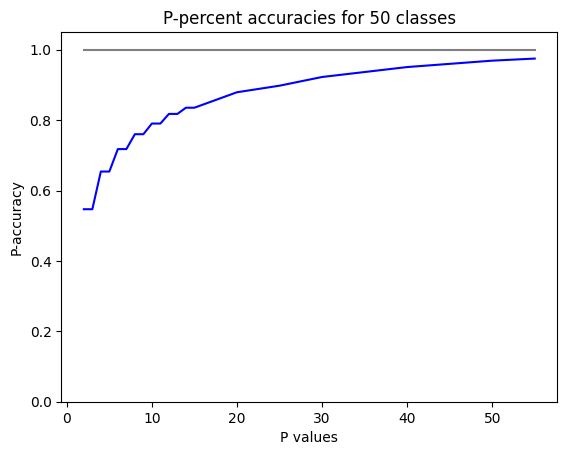

In [ ]:
top_p_percent_plot(resnet50_pred_50classes, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 40, 50, 55], " 50 classes", "blue")

The 3 highest 2-percent accuracy: [0.9957219251336898, 0.9047619047619048, 0.8125]
Some examples from these 3 classes:


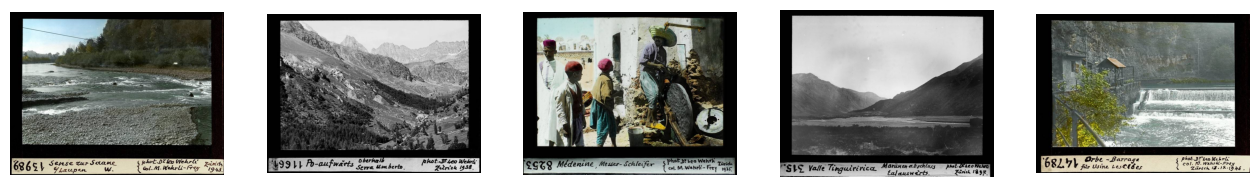

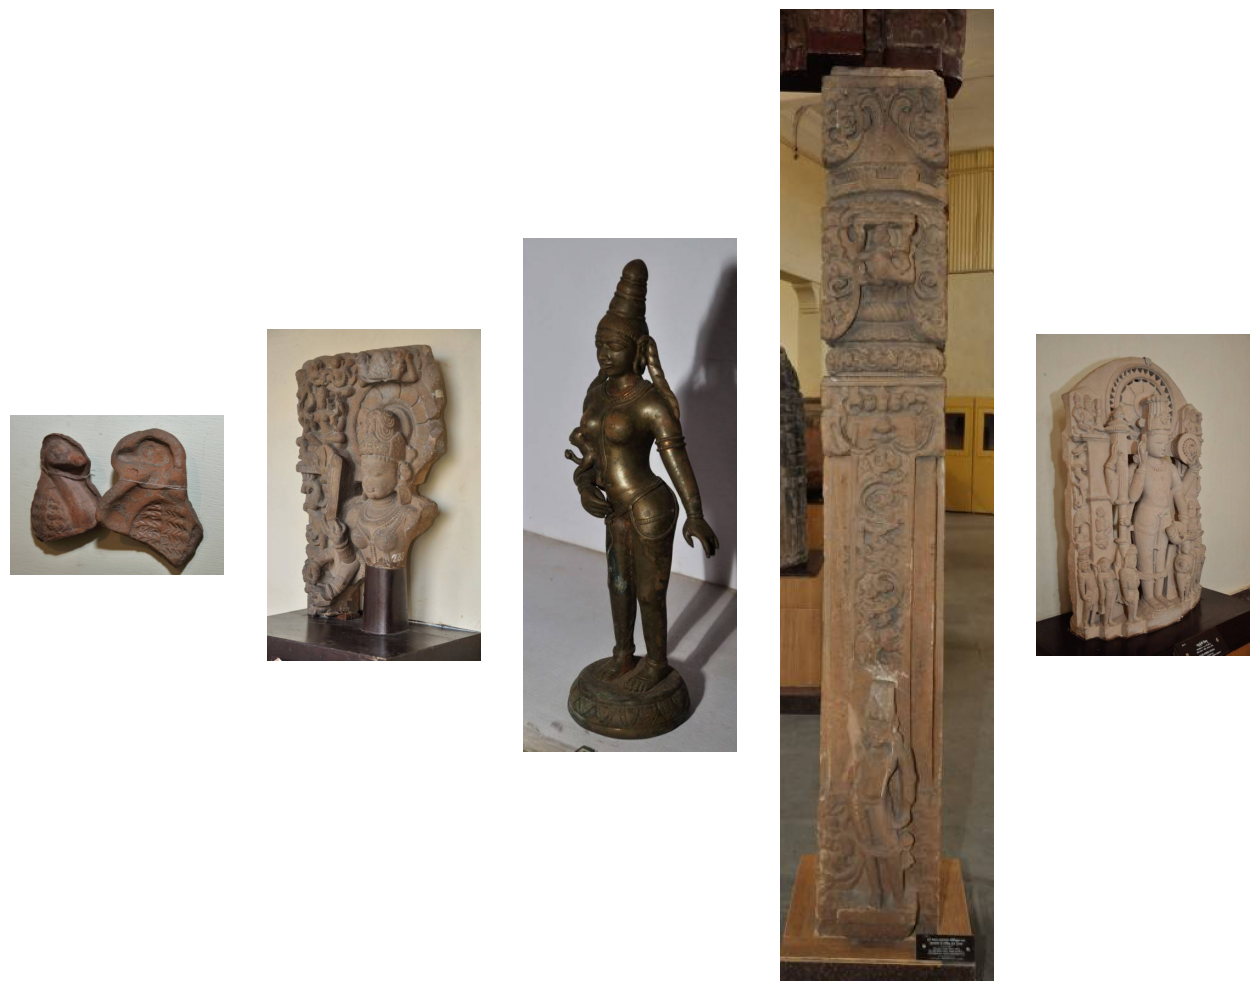

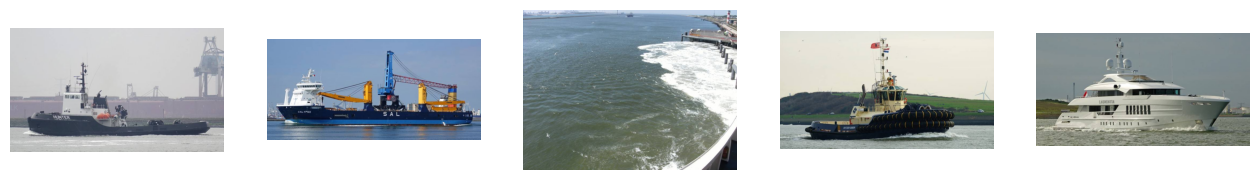

The 3 lowest 2-percent accuracy: [0.09401709401709402, 0.1348314606741573, 0.13829787234042554]
Some examples from these 3 classes:


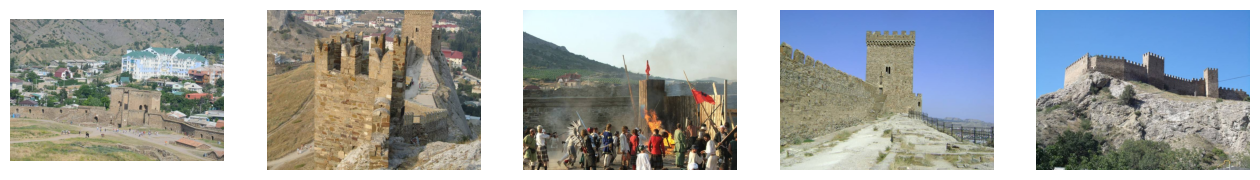

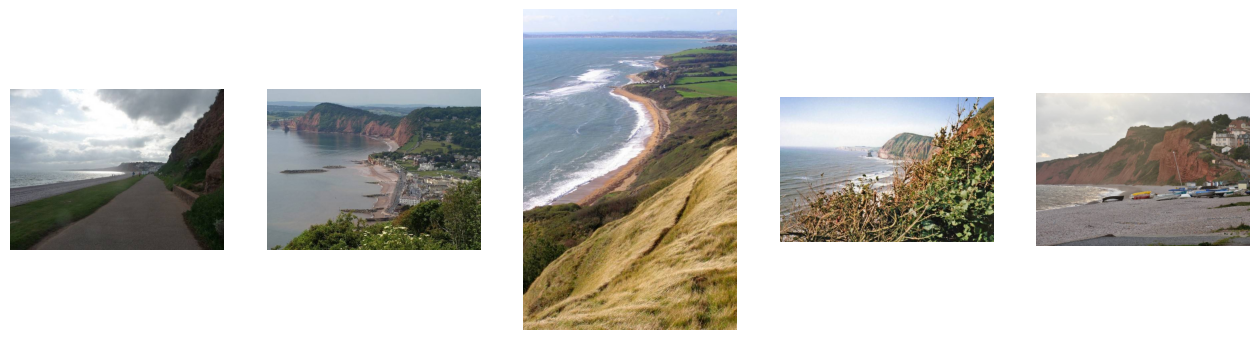

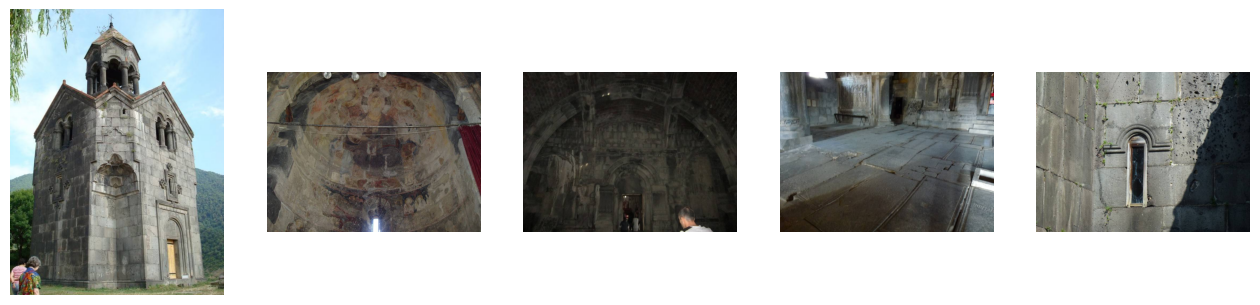

In [18]:
best_worst_class(resnet50_pred_50classes, 3, 2)

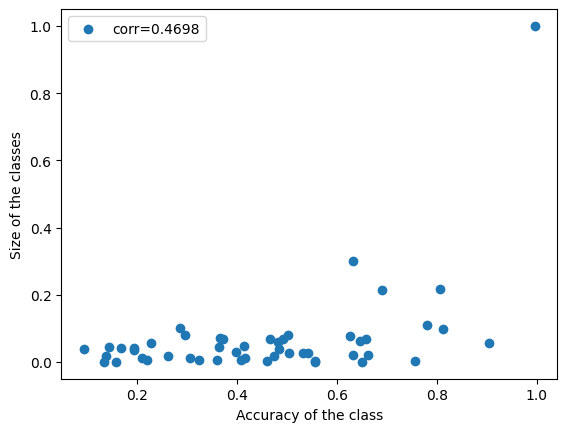

In [ ]:
acc_class_size(resnet50_pred_50classes)

## with 1971 classes
We made another model which was trained on 1971 classes. <br>
This mdoel had worse accuracy, but considering the large state space, this is not surprising. We measured the model accurcy by TOP_k accuracy, which means, the model had k guesses when predicting.

In [19]:
resnet50_pred_1971classes=pd.read_csv(f'{path}/Resnet50_atLeast100TrainPic_1948classes_val_pred.csv')
resnet50_pred_1971classes.head(5)

138982    126637         20409     83144        113209    177870  \
0  0.000132  0.006019  1.415530e-03  0.003281  9.755789e-07  0.003648   
1  0.000137  0.013857  5.228064e-03  0.003602  3.535477e-02  0.002185   
2  0.000411  0.030758  6.766553e-04  0.005875  1.750169e-04  0.003690   
3  0.000364  0.002732  4.022392e-08  0.000169  8.448668e-12  0.000388   
4  0.000020  0.000672  2.084407e-03  0.000907  4.686060e-11  0.002519   

         194914    149980    139894      1924  ...        108517  \
0  1.466364e-04  0.000445  0.000271  0.000179  ...  5.947373e-07   
1  3.669769e-03  0.003483  0.007518  0.009307  ...  3.826639e-04   
2  7.284029e-04  0.002944  0.007415  0.007999  ...  1.002625e-04   
3  1.786702e-02  0.000150  0.000419  0.001578  ...  2.570577e-08   
4  7.997589e-07  0.000136  0.000041  0.000004  ...  1.016889e-12   

          17599        115091         30196         85018         47304  \
0  8.504005e-04  2.703339e-04  1.288987e-04  6.350642e-05  2.429904e-04   
1  3.585056e-05  7.911792e-05  1.376858e-05  4.316525e-05  4.231421e-05   
2  1.996789e-04  1.249502e-04  4.559983e-05  6.526672e-04  2.476981e-04   
3  3.001215e-11  2.493146e-13  2.384550e-10  2.471887e-12  4.406538e-09   
4  3.409093e-04  8.638234e-05  2.382528e-04  2.129989e-04  1.157348e-04   

         170717        128320  picture  original_class  
0  1.281671e-04  4.400961e-04  1363292          175360  
1  2.064112e-04  1.889725e-05  1093142          139980  
2  1.241747e-04  2.495265e-04  1518392          194914  
3  2.716071e-11  3.969909e-07  1222961          157472  
4  3.915588e-04  6.666356e-05  1347334          173350  

[5 rows x 1973 columns]

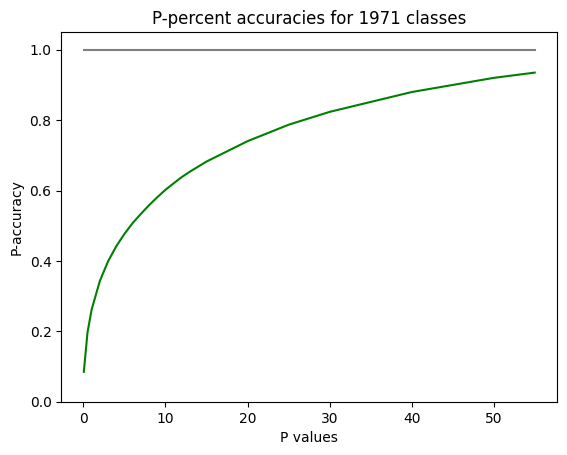

In [ ]:
top_p_percent_plot(resnet50_pred_1971classes, [1/1971*100, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 40, 50, 55], " 1971 classes", "green")

For the best classes it makes sense to run the best_worst_class function with top 1 accuracy, because otherwise there would be many classes with accuracy of 1. In this case there are many classes with accuracy 0, so this part is unimportant.

The 3 highest 0.050735667174023336-percent accuracy: [0.9597989949748744, 0.8636363636363636, 0.8387096774193549]
Some examples from these 3 classes:


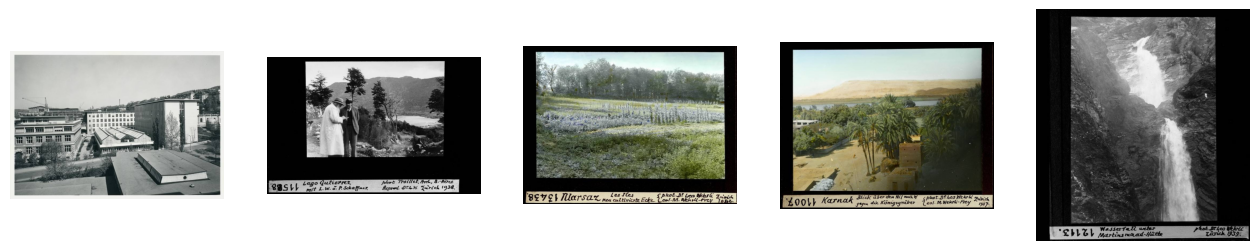

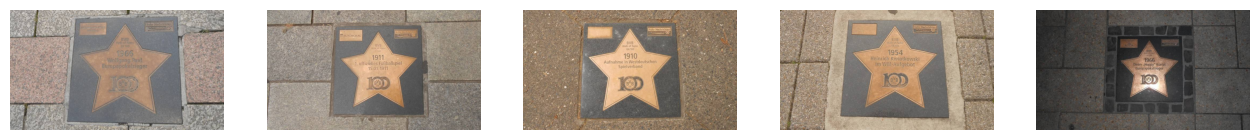

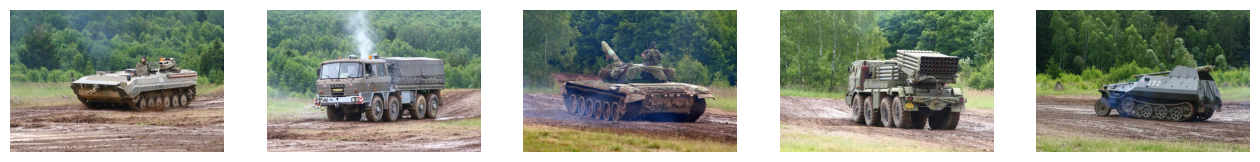

The 3 lowest 0.050735667174023336-percent accuracy: [0.0, 0.0, 0.0]
Some examples from these 3 classes:


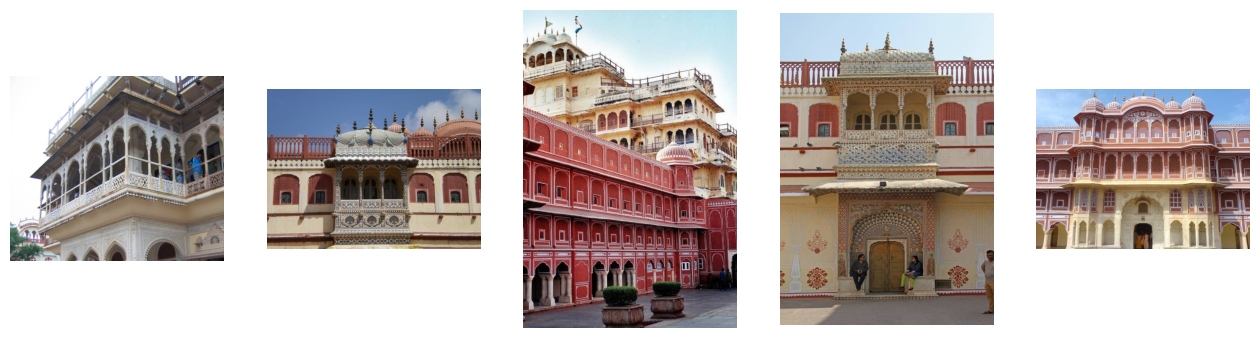

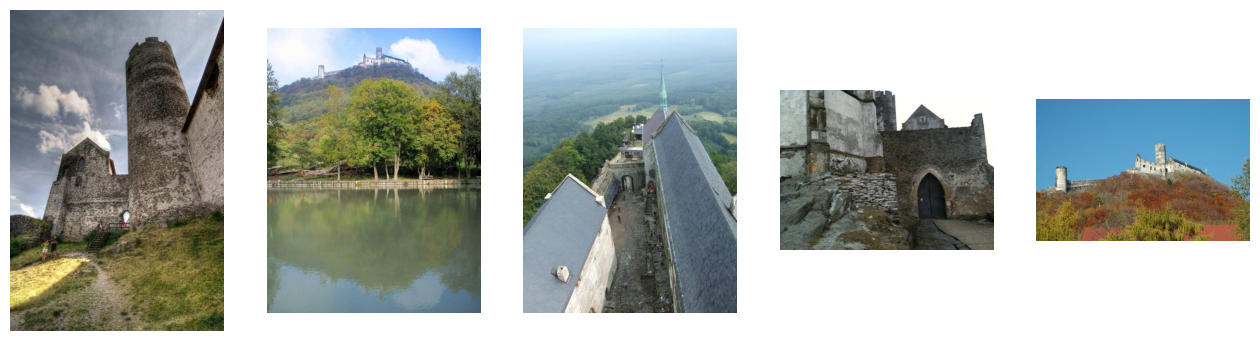

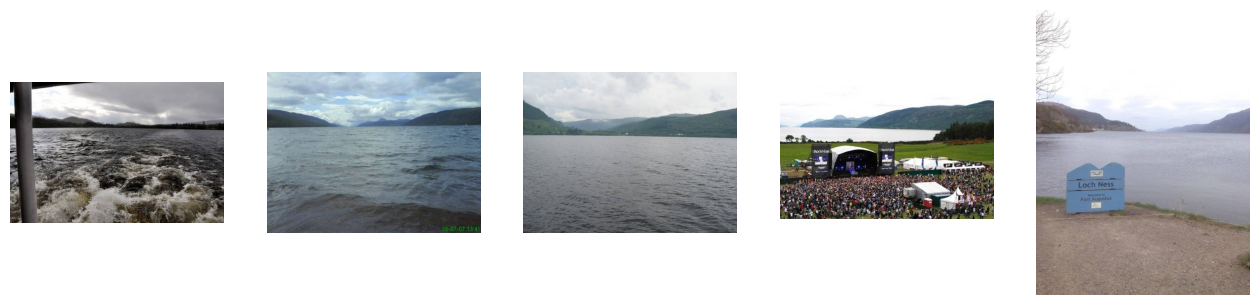

In [20]:
best_worst_class(resnet50_pred_1971classes, 3, 1/1971*100)

For the worst classes it makes sense to run the best_worst_class function with top p accuracy, where p is quite large, because otherwise there would be many classes with accuracy of 0. In this case there are many classes with accuracy 1, so the best classes part is unimportant.

The 3 highest 20-percent accuracy: [1.0, 1.0, 1.0]
Some examples from these 3 classes:


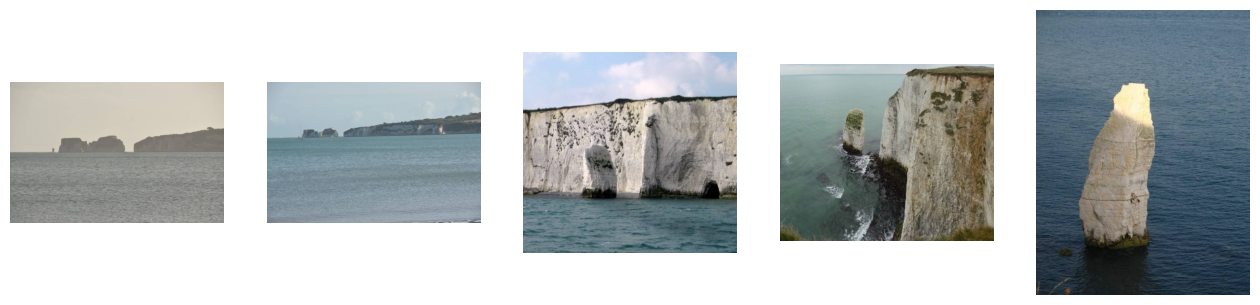

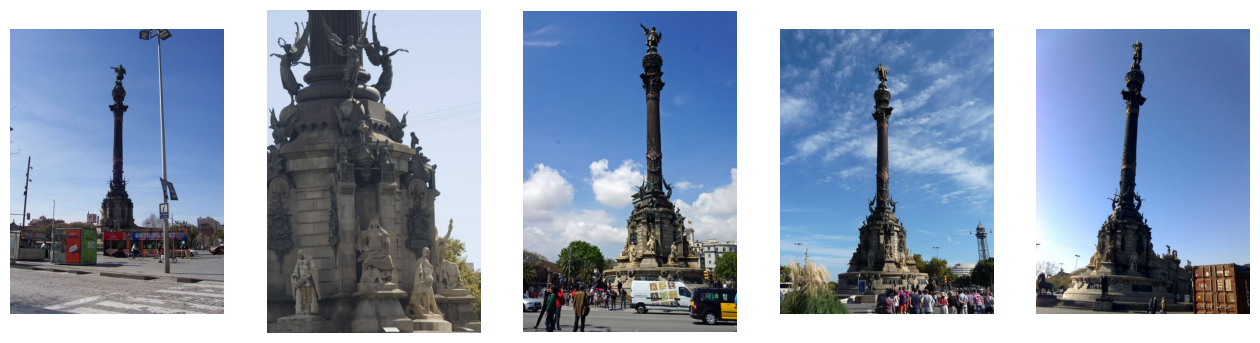

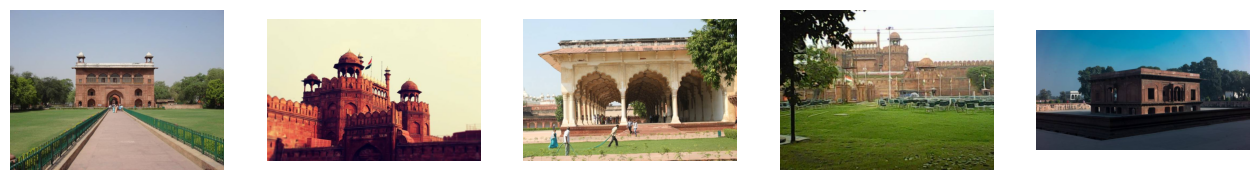

The 3 lowest 20-percent accuracy: [0.06666666666666667, 0.07142857142857142, 0.07142857142857142]
Some examples from these 3 classes:


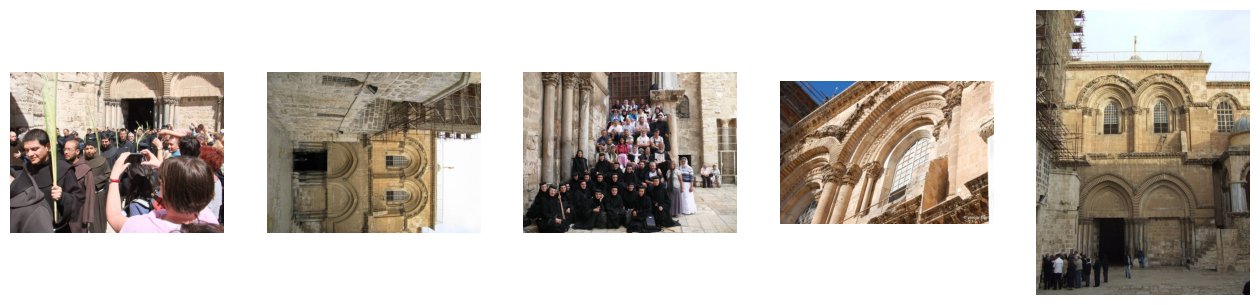

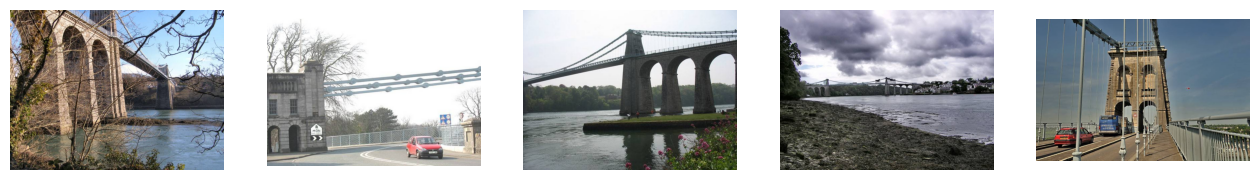

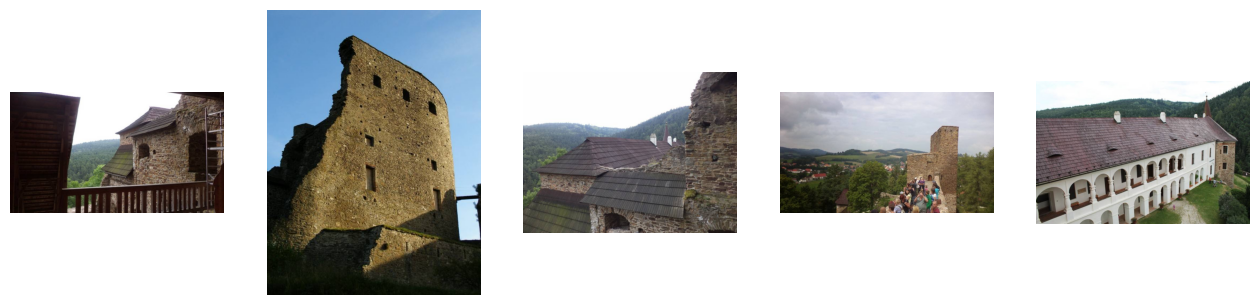

In [21]:
best_worst_class(resnet50_pred_1971classes, 3, 20)


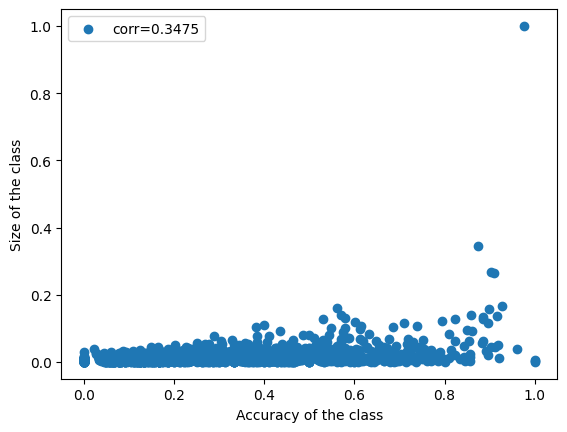

In [ ]:
acc_class_size(resnet50_pred_1971classes)